In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import wget
import os
import pathlib

In [24]:
imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

In [25]:
tf_class_labels = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog', 'Horse', 'Ship','Truck']

In [26]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [27]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [28]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [29]:
MAX_PREDS = 5
MIN_SCORE = 0.8 
def show_preds(logits, image, correct_class_label=None, tf_class_logits=False):
  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_class_label is not None:
    ax1.set_title(tf_class_labels[correct_class_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_class_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(tf_class_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

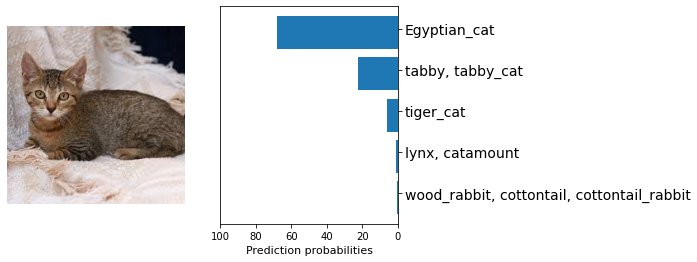

In [30]:
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSq2O4qf2vIH6qsxCln2H2NlAV02riDUhzMNg&usqp=CAU"
image = load_image_from_url(img_url)
logits = imagenet_module(image)
show_preds(logits, image[0])

In [31]:
dataset_name = 'cifar10'
ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
ds = ds[0]
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 10

In [32]:
train_split = 0.8
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

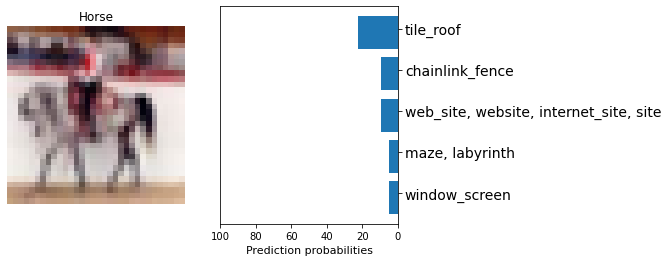

In [33]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)
  logits = imagenet_module(image)
  show_preds(logits, image[0], correct_class_label=features['label'].numpy())

In [34]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()
    
    
    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [35]:
IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [36]:
BATCH_SIZE = 512
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(1000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [37]:
lr = 0.001 * BATCH_SIZE / 512 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [38]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH), 
    validation_data=pipeline_test
)

Epoch 1/50
10/10 [==============================] - 28s 2s/step - loss: 0.8740 - accuracy: 0.7404 - val_loss: 0.2595 - val_accuracy: 0.9142
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 0.3810 - accuracy: 0.8832 - val_loss: 0.2618 - val_accuracy: 0.9192
Epoch 3/50
10/10 [==============================] - 15s 2s/step - loss: 0.4210 - accuracy: 0.8750 - val_loss: 0.2464 - val_accuracy: 0.9204
Epoch 4/50
10/10 [==============================] - 27s 3s/step - loss: 0.3306 - accuracy: 0.8949 - val_loss: 0.2346 - val_accuracy: 0.9258
Epoch 5/50
10/10 [==============================] - 15s 2s/step - loss: 0.3585 - accuracy: 0.8914 - val_loss: 0.2239 - val_accuracy: 0.9244
Epoch 6/50
10/10 [==============================] - 15s 2s/step - loss: 0.3121 - accuracy: 0.8961 - val_loss: 0.2088 - val_accuracy: 0.9304
Epoch 7/50
10/10 [==============================] - 14s 2s/step - loss: 0.3219 - accuracy: 0.8898 - val_loss: 0.2058 - val_accuracy: 0.9305
Epoch 8/50
10/10 [==